# Problem explanation

Problem description

Your goal is to predict the total_cases label for each (city, year, weekofyear) in the test set. There are two cities, San Juan and Iquitos, with test data for each city spanning 5 and 3 years respectively. You will make one submission that contains predictions for both cities. The data for each city have been concatenated along with a city column indicating the source: sj for San Juan and iq for Iquitos. The test set is a pure future hold-out, meaning the test data are sequential and non-overlapping with any of the training data. Throughout, missing values have been filled as NaNs.

    Features
    List of features
    Example of features

    Performance metric
    Mean absolute error

    Submission Format
    Format example

The features in this dataset

You are provided the following set of information on a (year, weekofyear) timescale:

(Where appropriate, units are provided as a _unit suffix on the feature name.)
City and date indicators

    city – City abbreviations: sj for San Juan and iq for Iquitos
    week_start_date – Date given in yyyy-mm-dd format

NOAA's GHCN daily climate data weather station measurements

    station_max_temp_c – Maximum temperature
    station_min_temp_c – Minimum temperature
    station_avg_temp_c – Average temperature
    station_precip_mm – Total precipitation
    station_diur_temp_rng_c – Diurnal temperature range

PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)

    precipitation_amt_mm – Total precipitation

NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)

    reanalysis_sat_precip_amt_mm – Total precipitation
    reanalysis_dew_point_temp_k – Mean dew point temperature
    reanalysis_air_temp_k – Mean air temperature
    reanalysis_relative_humidity_percent – Mean relative humidity
    reanalysis_specific_humidity_g_per_kg – Mean specific humidity
    reanalysis_precip_amt_kg_per_m2 – Total precipitation
    reanalysis_max_air_temp_k – Maximum air temperature
    reanalysis_min_air_temp_k – Minimum air temperature
    reanalysis_avg_temp_k – Average air temperature
    reanalysis_tdtr_k – Diurnal temperature range

Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements

    ndvi_se – Pixel southeast of city centroid
    ndvi_sw – Pixel southwest of city centroid
    ndvi_ne – Pixel northeast of city centroid
    ndvi_nw – Pixel northwest of city centroid


# Setup and imports

In [0]:
SETUP = True

In [0]:
try:
    %tensorflow_version 2.x
except:
    pass

TensorFlow 2.x selected.


In [0]:
if SETUP:
    !pip install -q -U toai
    !pip install fbprophet
    !pip install impyute

In [0]:
print(__import__("tensorflow").__version__)
print(__import__("toai").__version__)

2.1.0
0.5.1


In [0]:
from toai.imports import *
from toai.image import ImageAugmentor, ImageParser, ImageResizer, ImageDataContainer
from toai.data.utils import split_df
from toai.encode import CategoricalEncoder
from typing import *
import tensorflow as tf
from tensorflow import keras

import os
import matplotlib.pyplot as plt

from matplotlib import cm

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

from fbprophet import Prophet

from impyute.imputation.cs import mice
from impyute.imputation.cs import fast_knn

from sklearn import preprocessing

In [0]:
DATA_DIR = Path("data/Disease")
DATA_DIR.mkdir(parents=True, exist_ok=True)

TEMP_DIR = Path("temp/Disease")
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
train_df = pd.read_csv(DATA_DIR/'dengue_features_train.csv')
train_labels1 = pd.read_csv(DATA_DIR/'dengue_labels_train.csv')
test_df = pd.read_csv(DATA_DIR/'dengue_features_test.csv')

In [0]:
test_df_pure = pd.read_csv(DATA_DIR/'dengue_features_test.csv')

In [0]:
test_city = test_df['city']
test_year = test_df['year']
test_weekofyear = test_df['weekofyear']

In [0]:
train_df['total_cases'] = train_labels1.total_cases

In [0]:
train_df_iq = train_df[train_df['city']=='iq']
train_df_sj = train_df[train_df['city']=='sj']

In [0]:
train_labels1.head()

In [0]:
train_labels_iq = train_labels1[train_labels1['city']=='iq']
train_labels_sj = train_labels1[train_labels1['city']=='iq']

In [0]:
train_df['total_cases'] = train_labels['total_cases']

In [0]:
train_labels

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


In [0]:
train_df.head().T

,0,1,2,3,4
city,sj,sj,sj,sj,sj
year,1990,1990,1990,1990,1990
weekofyear,18,19,20,21,22
week_start_date,1990-04-30,1990-05-07,1990-05-14,1990-05-21,1990-05-28
ndvi_ne,0.1226,0.1699,0.03225,0.128633,0.1962
ndvi_nw,0.103725,0.142175,0.172967,0.245067,0.2622
ndvi_se,0.198483,0.162357,0.1572,0.227557,0.2512
ndvi_sw,0.177617,0.155486,0.170843,0.235886,0.24734
precipitation_amt_mm,12.42,22.82,34.54,15.36,7.52
reanalysis_air_temp_k,297.573,298.211,298.781,298.987,299.519


In [0]:
test_city = test_df['city']
test_year = test_df['year']
test_weekofyear = test_df['weekofyear']

In [0]:
target = train_labels['total_cases']


In [0]:
#one city
sj_features = df_features.loc['sj']
sj_labels = df_labels.loc['sj']

In [0]:
sj_features.head().T

city,sj,sj,sj,sj,sj
year,1990,1990,1990,1990,1990
weekofyear,18,19,20,21,22
week_start_date,1990-04-30,1990-05-07,1990-05-14,1990-05-21,1990-05-28
ndvi_ne,0.1226,0.1699,0.03225,0.128633,0.1962
ndvi_nw,0.103725,0.142175,0.172967,0.245067,0.2622
ndvi_se,0.198483,0.162357,0.1572,0.227557,0.2512
ndvi_sw,0.177617,0.155486,0.170843,0.235886,0.24734
precipitation_amt_mm,12.42,22.82,34.54,15.36,7.52
reanalysis_air_temp_k,297.573,298.211,298.781,298.987,299.519
reanalysis_avg_temp_k,297.743,298.443,298.879,299.229,299.664


In [417]:
[x.shape for x in [train_df,train_labels1]]

[(1456, 24), (1456, 4)]

In [0]:
#iq_features.mean()

In [0]:
#df_features.head(3).T

In [0]:
train_df.rename(columns={
  
    'station_max_temp_c' : 'Maximum temperature',
    'station_min_temp_c' : 'Minimum temperature',
    'station_avg_temp_c' : 'Average temperature',
    'station_precip_mm' : 'Total precipitation',
    'station_diur_temp_rng_c' : 'Diurnal temperature range',
    'precipitation_amt_mm' : 'Total precipitation',
    'reanalysis_sat_precip_amt_mm' : 'Total precipitation',
    'reanalysis_dew_point_temp_k' : 'Mean dew point temperature',
    'reanalysis_air_temp_k' : 'Mean air temperature',
    'reanalysis_relative_humidity_percent' : 'Mean relative humidity',
    'reanalysis_specific_humidity_g_per_kg' : 'Mean specific humidity',
    'reanalysis_precip_amt_kg_per_m2' : 'Total precipitation',
    'reanalysis_max_air_temp_k' : 'Maximum air temperature',
    'reanalysis_min_air_temp_k' : 'Minimum air temperature',
    'reanalysis_avg_temp_k' : 'Average air temperature',
    'ndvi_se' : 'Pixel SE of city centroid',
    'ndvi_sw' : 'Pixel SW of city centroid',
    'ndvi_ne' : 'Pixel NE of city centroid',
    'ndvi_nw' : 'Pixel NW of city centroid',
    
},inplace = True)

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [0]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [0]:
train_df.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


In [0]:
train_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [0]:
train_df.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

# preprocess

In [0]:
from sklearn.compose import ColumnTransformer

In [0]:
#standart_scaler = StandardScaler()

In [0]:
#standart_scaler.fit(train_df)

In [0]:
#scaler = MinMaxScaler(feature_range=(0,1))

In [0]:
#scaler.fit(train_df)

In [0]:
#train_df=scaler.transform(train_df) 

In [0]:
#print(train_df)

In [0]:
train_df.fillna(method='ffill', inplace=True)

In [0]:
train_df.drop('week_start_date',axis=1,inplace=True)

In [0]:
enc = preprocessing.LabelEncoder()

In [0]:
train_df['city'] = enc.fit_transform(train_df['city'])

In [0]:
train_target = train_labels1['total_cases']

In [0]:
train_labels1

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


In [0]:
#columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])], remainder='passthrough')


In [0]:
#train_df = (columnTransformer.fit_transform(train_df))

In [0]:


cont_cols = [
      'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm',
    
]

cat_cols = ["city",
            "year",
            "weekofyear",
            ]

target_col = 'total_cases'



In [0]:
train_data, test_data, train_labels, test_labels = train_test_split(train_df[cont_cols+cat_cols],train_df[target_col])

In [0]:
target

In [0]:
[x.shape for x in (train_data, test_data, train_labels, test_labels)]

[(1092, 23), (364, 23), (1092,), (364,)]

In [0]:
def cats_fit_transform(df, cat_cols):
    df = df.copy()
    cat_features_map = {}
    df[cat_cols] = df[cat_cols].astype("category")
    for cat_col in cat_cols:
        cat_features_map[cat_col] = dict(enumerate(df[cat_col].cat.categories, start=1))
        df[cat_col] = df[cat_col].cat.codes + 1
    return df, cat_features_map

In [0]:
def cats_transform(df, cat_features_map):
    df = df.copy()
    for cat_col in cat_features_map:
        df[cat_col] = df[cat_col].map(
            {value: key for key, value in cat_features_map[cat_col].items()}
        )
        df[cat_col].fillna(value=0, inplace=True)
        df[cat_col] = df[cat_col].astype(int)
    return df



In [0]:
def conts_fit_transform(df, cont_cols):
    df = df.copy()
    cont_features_map = {}
    df[cont_cols] = df[cont_cols].astype(float)
    for cont_col in cont_cols:
        cont_features_map[cont_col] = {
            "mean": df[cont_col].mean(),
            "std": df[cont_col].std(),
        }
        df[cont_col] = (
            df[cont_col] - cont_features_map[cont_col]["mean"]
        ) / cont_features_map[cont_col]["std"]
    return df, cont_features_map

In [0]:
def conts_transform(df, cont_features_map):
    df = df.copy()
    for cont_col in cont_features_map:
        df[cont_col] = (
            df[cont_col] - cont_features_map[cont_col]["mean"]
        ) / cont_features_map[cont_col]["std"]
    return df



In [0]:
train_data, cat_features_map = cats_fit_transform(train_data, cat_cols)

In [0]:
train_data, cont_features_map = conts_fit_transform(train_data, cont_cols)

In [0]:
train_df.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,1,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,1,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,1,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [0]:
train_data.isna().sum()

In [0]:
train_labels

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


In [0]:
#df_with_missing_imputed = datawig.SimpleImputer.complete(train_df)

In [0]:
train_df.shape,train_labels.shape

((1456, 24), (1456, 4))

In [0]:
target

In [0]:
train_df.head(1)

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,1990,18,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.0,73.365714,12.42,14.012857,2.628571,25.442857,6.9,29.4,20.0,16.0


# EDA

In [0]:
%matplotlib inline

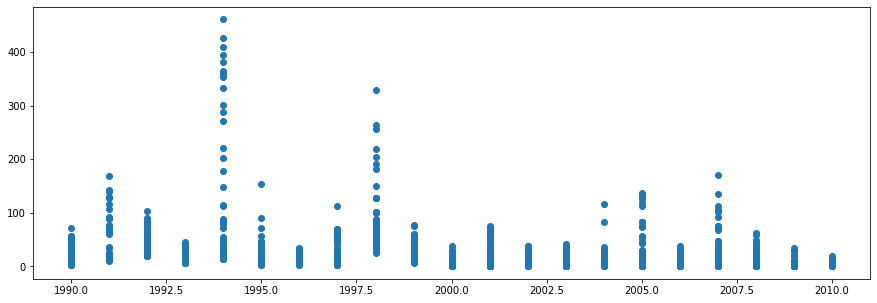

In [0]:
plt.figure(figsize=(15,5))
plt.scatter(train_labels.year,train_labels.total_cases)

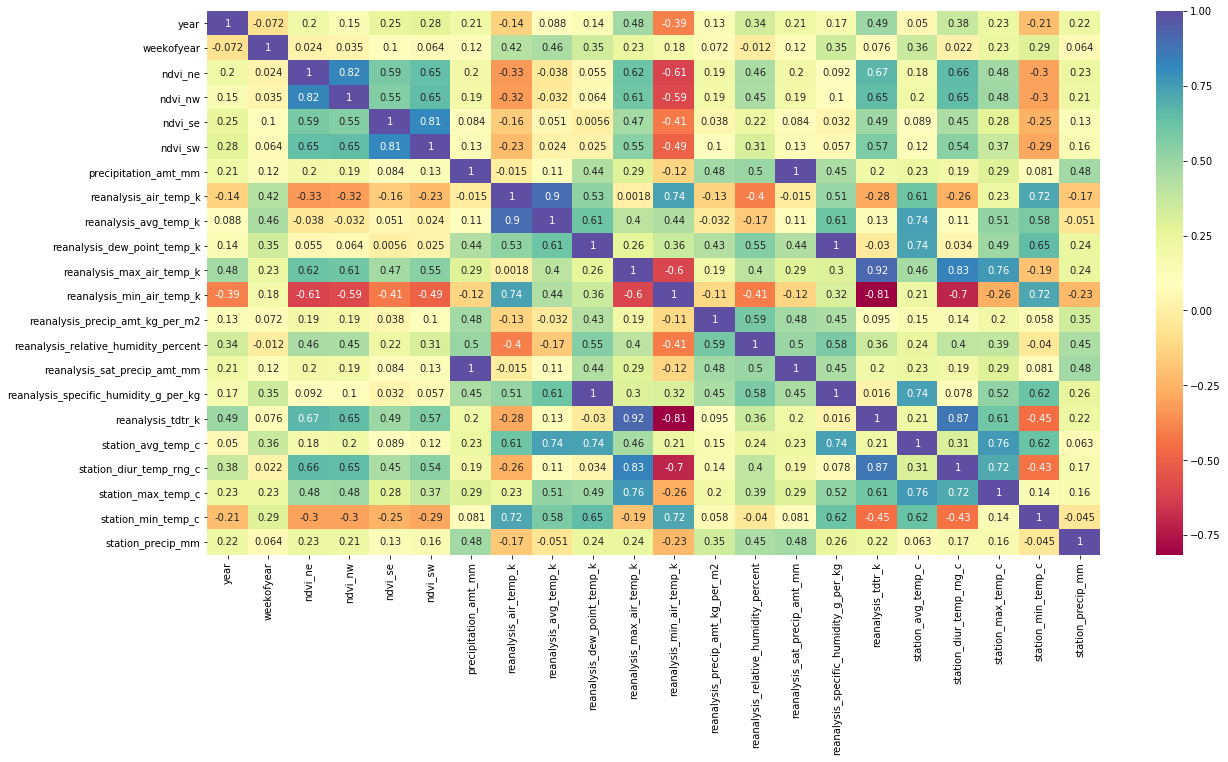

In [0]:
data = plt.subplots(figsize=(20, 10)) 
sns.heatmap(train_df.corr(),annot=True,cmap='Spectral')

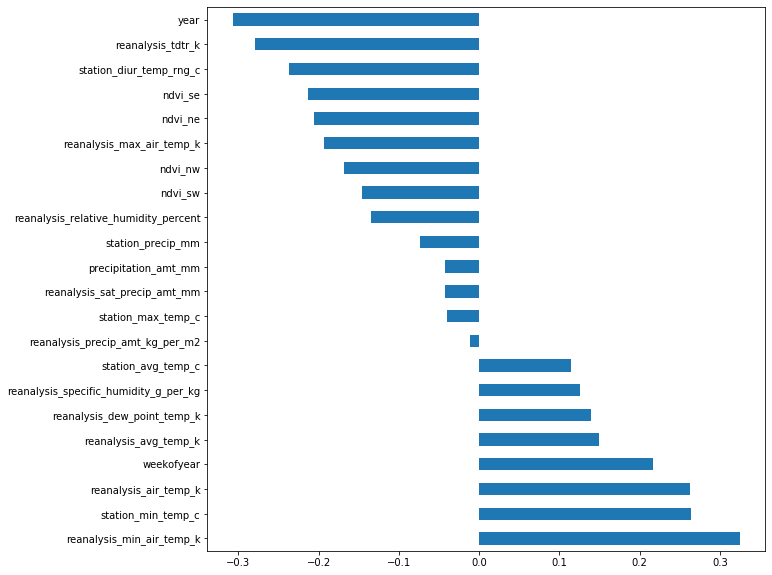

In [0]:
(train_df.corr()
     .total_cases
     .drop('total_cases')
     .sort_values(ascending=False)
     .plot
     .barh(figsize=(10, 10))
    
)


In [0]:
train_df

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c
0,14.012857,292.414286,25.442857,20.0
1,15.372857,293.951429,26.714286,22.2
2,16.848571,295.434286,26.714286,22.8
3,16.672857,295.310000,27.471429,23.3
4,17.210000,295.821429,28.942857,23.9
...,...,...,...,...
1451,18.485714,296.825714,28.633333,22.4
1452,18.070000,296.452857,27.433333,21.7
1453,17.008571,295.501429,24.400000,19.2
1454,16.815714,295.324286,25.433333,21.0


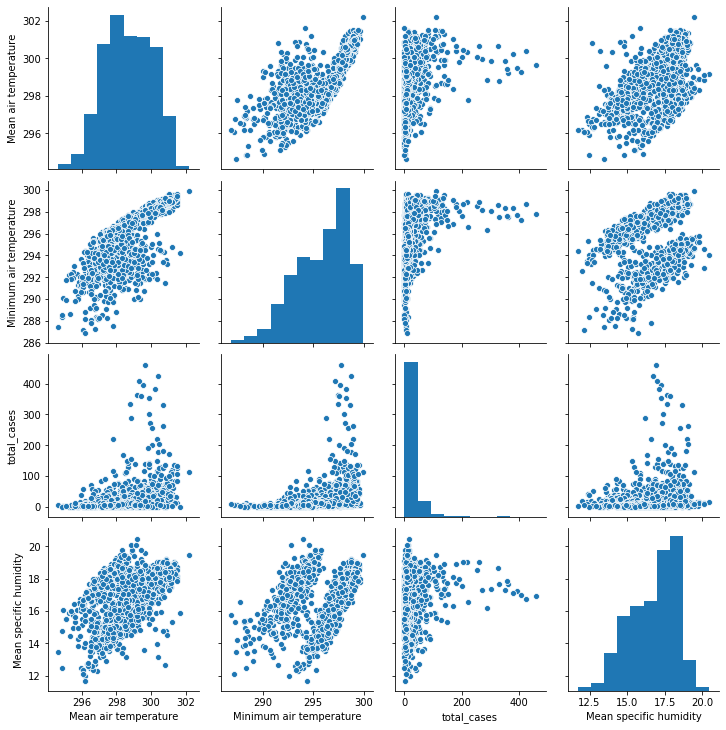

In [0]:
pp = sns.pairplot(
    
  df_features, 
  vars=['Mean air temperature', 'Minimum air temperature', 'total_cases','Mean specific humidity'],
)


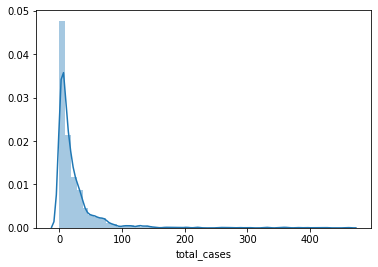

In [0]:
sns.distplot(df_features.total_cases)

# Models

In [0]:
rs_rf2 = RandomizedSearchCV(
    estimator=RandomForestRegressor(n_estimators=300),
    param_distributions={
        'max_depth': np.arange(10, 1000),
        'min_samples_leaf': np.arange(3, 20, 3),
        'max_features': ['sqrt', 'log2', 0.2],
        'min_samples_split': np.arange(2, 20),
        'min_samples_leaf': np.arange(1, 10),
    },
    n_iter=200,
    cv=3,
    n_jobs=-1,
    verbose=1,
)

In [0]:
rfc_rs3 = RandomizedSearchCV(
    estimator=RandomForestRegressor(n_estimators=300),
    param_distributions={
        "max_depth": np.arange(10, 1000),
        "max_features": ["sqrt", "log2", 0.2],
        "min_samples_leaf": np.arange(5, 500),
    },
    n_iter=10,
    cv=5,
    n_jobs=-1,
    verbose=1,    
)

In [0]:
rs_rf.fit(train_data, train_labels)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=300,
                              

In [0]:
rs_rf2.fit(train_data, train_labels)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=300,
                              

In [0]:
rs_rf2.best_score_

0.44585218640920726

In [0]:
predictions = rs_rf2.predict(test_df)

In [0]:
rs_rf2.predict(test_df)

In [0]:
predictions = predictions.astype(int)

In [0]:
submission_rf = pd.DataFrame(predictions, columns=["total_cases"])

In [0]:
submission_rf.insert(0, 'city', test_city)
submission_rf.insert(1, 'year', test_year)
submission_rf.insert(2, 'weekofyear', test_weekofyear)
submission_rf.reset_index()
submission_rf.to_csv('Submission_rf.csv', index = False)

In [0]:
test_data2 = cats_transform(test_df, cat_features_map)

In [0]:
test_data2 = conts_transform(test_df, cont_features_map)

In [0]:
predictions = rs_rf2.predict(test_data2).astype(int)

In [0]:
submission_rf3 = pd.DataFrame(predictions, columns=["total_cases"])

In [0]:
submission_rf3.insert(0, 'city', test_city)
submission_rf3.insert(1, 'year', test_year)
submission_rf3.insert(2, 'weekofyear', test_weekofyear)
submission_rf3.reset_index()
submission_rf3.to_csv('Submission_rf3.csv', index = False)

In [0]:
submission_rf2.to_csv('Submission_rf2.csv', index = False)

In [0]:
rfc_rs3.fit(train_data, train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=300,
                              

In [0]:
rfc_rs3.best_score_

0.22335709142093624

In [0]:
predictions = 

In [0]:
rs_rf.best_score_

0.45355694589911016

In [0]:
#rs_rf.best_score_(test_data, test_labels)

In [0]:
rfc_rs.score(test_data,test_labels)

In [0]:
predictions = rs_rf.predict(test_data)

In [0]:
predictions

In [0]:
test_data

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,city,year,weekofyear
490,0.050167,0.039467,0.169983,0.161283,62.41,300.644286,300.635714,296.824286,303.5,298.9,64.72,79.837143,62.41,18.345714,2.214286,28.714286,7.957143,34.4,23.9,38.9,1,1999,39
1440,0.311729,0.292686,0.272586,0.394800,57.78,298.837143,300.092857,298.141429,306.9,292.8,86.10,96.250000,57.78,20.091429,8.814286,28.550000,10.050000,35.4,21.4,44.5,0,2010,10
90,0.122533,0.131050,0.188843,0.168871,0.00,297.091429,297.335714,293.021429,299.5,295.6,5.11,78.291429,0.00,14.482857,2.357143,24.857143,7.442857,30.6,20.0,1.3,1,1992,4
1314,0.385186,0.405071,0.310629,0.438129,39.09,299.575714,301.385714,295.447143,309.6,294.8,38.28,80.450000,39.09,17.010000,11.600000,28.400000,10.600000,34.2,21.8,145.1,0,2007,41
15,0.150567,0.128033,0.206957,0.168243,90.75,299.958571,299.957143,297.035714,302.6,298.5,101.90,84.178571,90.75,18.515714,1.857143,28.042857,6.685714,32.8,22.8,44.7,1,1990,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0.200757,0.237729,0.223643,0.204357,0.00,298.537143,300.135714,291.387143,308.7,291.0,0.20,66.664286,0.00,13.158571,14.642857,27.100000,12.175000,33.5,17.8,10.9,0,2001,32
1418,0.232271,0.272500,0.271571,0.285386,20.58,298.707143,300.128571,296.561429,308.3,294.3,43.94,89.310000,20.58,18.134286,9.285714,27.640000,11.660000,34.8,21.0,29.4,0,2009,41
437,0.050850,0.046850,0.231586,0.206686,82.87,300.130000,300.185714,297.060000,302.1,298.8,55.80,83.331429,82.87,18.581429,1.857143,27.771429,6.228571,32.2,24.4,123.6,1,1998,39
682,0.050633,0.055875,0.109350,0.098714,18.25,299.752857,299.842857,295.397143,301.6,297.8,20.10,77.141429,18.25,16.758571,2.714286,27.400000,6.657143,31.1,22.8,33.8,1,2003,24


In [0]:
train_df

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
0,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,0,1
1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,0,1
2,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,0,1
3,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,0,1
4,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,1,0
1452,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,1,0
1453,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1,0
1454,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1,0


In [0]:
rfc_rs.fit(train_df, train_target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.8s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=300,
                              

In [0]:
rfc_rs.best_score_

AttributeError: ignored

In [0]:
predictions = rs_rf.predict(test_df)

In [0]:
%matplotlib inline

In [0]:
rfc_rs = RandomizedSearchCV(
    estimator=RandomForestRegressor(n_estimators=100),
    param_distributions={
        "max_depth": np.arange(10, 1000),
        "max_features": ["sqrt", "log2", 0.2],
        "min_samples_leaf": np.arange(5, 100),
    },
    n_iter=10,
    cv=5,
    n_jobs=-1,
    verbose=1,    
)

In [0]:
rfc_rs.fit(df_features, df_labels)

In [0]:
rfc_rs.best_score_

In [0]:
rfc_rs.best_params_

{'max_depth': 945, 'max_features': 'sqrt', 'min_samples_leaf': 25}

In [0]:
%matplotlib inline

In [0]:
train_data

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,city,year,weekofyear
608,-0.215841,1.373386,0.633672,-0.264954,-1.039612,-0.187377,-0.567452,-0.292280,-0.730503,0.400990,-0.602753,-0.240015,-1.039612,-0.393637,-0.574207,-1.312676,-0.763830,-1.529148,-0.275143,-0.536140,2,13,2
756,-0.825702,-1.064111,-2.238273,-1.639461,-0.621171,0.900786,0.607104,0.210840,-0.384603,0.996809,-0.370661,-0.698538,-0.621171,0.169963,-0.685143,0.051395,-0.777351,-0.669343,1.136429,-0.663595,2,15,46
98,-0.592048,-0.349637,-0.815388,-0.791464,-1.039612,-0.562095,-0.853929,-1.045062,-0.919175,-0.115386,-0.824866,-0.671224,-1.039612,-1.077073,-0.598859,-0.821610,-0.067513,-0.669343,-0.275143,-0.725198,2,3,12
186,-0.211083,0.468161,0.822295,0.863016,1.009298,-0.099520,-0.429943,-0.016988,-0.699057,0.400990,1.659594,-0.017682,1.009298,-0.077197,-0.837166,-0.221419,-0.662425,-0.365882,0.045669,0.158488,2,4,47
478,-0.278983,-0.331928,-0.232705,-0.251956,0.596213,0.591697,0.257602,0.424429,-0.604721,0.798202,0.293076,-0.208282,0.596213,0.338481,-0.697469,0.171434,-1.074807,-0.669343,0.430643,-0.049688,2,10,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,-0.590638,-0.401925,-0.174950,-0.364860,-0.950568,0.775880,0.549808,0.065600,-0.290267,0.758481,-0.724221,-0.729267,-0.950568,-0.014471,-0.635838,0.760712,-0.317646,0.190462,0.751455,-0.725198,2,13,22
1316,1.877853,1.626285,2.880278,2.714992,1.342265,-1.285067,-0.819552,0.451009,0.558758,-1.545350,0.571369,1.757565,1.342265,0.500446,0.855635,-0.210506,0.646831,-0.163575,-0.788442,0.857363,1,18,43
717,-1.264110,-0.859557,0.633013,-0.085727,-1.039612,-0.281586,-0.567452,-1.171317,-1.107847,0.599596,-0.836145,-1.072708,-1.039612,-1.248399,-0.804296,-1.749178,-0.601582,-1.782031,-1.365903,-0.508525,2,15,7
101,-0.233638,0.047340,-1.082599,-0.914617,-0.075301,-0.016955,-0.269516,-0.721356,-0.541830,0.043499,-0.661318,-0.830090,-0.075301,-0.764378,-0.335900,-0.145031,-0.074274,0.190462,-0.275143,-0.827161,2,3,15


In [0]:
def make_model(input_shape, layer_size, dropout_rate=0.0, n_layers=1, regularization=None, batch_norm=True):
    layers = [
        keras.layers.InputLayer(input_shape=input_shape)
      ]
  
    for _ in range(n_layers):
        if batch_norm:
            layers += [keras.layers.BatchNormalization()]
    
        layers += [
            keras.layers.Dense(
                layer_size,
                kernel_initializer="he_uniform",
                kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
            ),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(dropout_rate)
        ]
    
    layers += [keras.layers.Dense(1, activation="sigmoid")]
  
    return keras.Sequential(layers)



In [0]:
nn_model = make_model(
    input_shape=train_data.shape[1:],
    layer_size=64, 
    dropout_rate=0, 
    n_layers=1, 
    regularization=None, 
    batch_norm=True,
)



In [0]:
nn_model.compile(
    optimizer = keras.optimizers.Adam(lr=1e-5),
    loss = keras.losses.MAE,
    metrics = [
        keras.metrics.MAE
    ]
)

In [0]:
PATIENCE = 60

nn_model_history = nn_model.fit(   
    train_data,
    train_labels,
    batch_size=256,
    validation_split = 0.2,
    epochs=500,
    
)


Train on 873 samples, validate on 219 samples
Epoch 1/500
873/873 [==============================] - 0s 42us/sample - loss: 25.2730 - mean_absolute_error: 25.2730 - val_loss: 23.6059 - val_mean_absolute_error: 23.6059
Epoch 2/500
873/873 [==============================] - 0s 26us/sample - loss: 25.2725 - mean_absolute_error: 25.2725 - val_loss: 23.6051 - val_mean_absolute_error: 23.6051
Epoch 3/500
873/873 [==============================] - 0s 25us/sample - loss: 25.2713 - mean_absolute_error: 25.2713 - val_loss: 23.6046 - val_mean_absolute_error: 23.6046
Epoch 4/500
873/873 [==============================] - 0s 28us/sample - loss: 25.2702 - mean_absolute_error: 25.2702 - val_loss: 23.6037 - val_mean_absolute_error: 23.6037
Epoch 5/500
873/873 [==============================] - 0s 27us/sample - loss: 25.2696 - mean_absolute_error: 25.2696 - val_loss: 23.6028 - val_mean_absolute_error: 23.6028
Epoch 6/500
873/873 [==============================] - 0s 25us/sample - loss: 25.2685 - mean_a

KeyboardInterrupt: ignored

In [0]:
train_df

In [0]:
train_df.total_cases

In [0]:
training_loss = nn_model.history.history['loss']
val_loss = nn_model.history.history['val_loss']
epoch_count = range(1, len(training_loss) + 1)

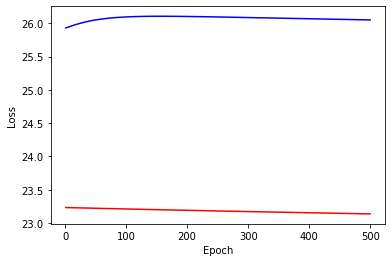

In [0]:
plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, val_loss, 'b')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [0]:
%matplotlib inline

In [0]:
%matplotlib inline

# Prophet

In [0]:
from fbprophet import Prophet

In [0]:
train = pd.read_csv(DATA_DIR/'dengue_features_train.csv')
labels = pd.read_csv(DATA_DIR/'dengue_labels_train.csv')
test = pd.read_csv(DATA_DIR/'dengue_features_test.csv')

In [0]:
train_labels['total_cases'] = labels['total_cases']
prophet_data = train[['city', 'week_start_date', 'total_cases']]

In [0]:
prophet_data 

,city,week_start_date,total_cases
0,sj,1990-04-30,4
1,sj,1990-05-07,5
2,sj,1990-05-14,4
3,sj,1990-05-21,3
4,sj,1990-05-28,6
...,...,...,...
1451,iq,2010-05-28,5
1452,iq,2010-06-04,8
1453,iq,2010-06-11,1
1454,iq,2010-06-18,1


In [0]:
prophet_data_sj = prophet_data[prophet_data['city'] == 'sj'].drop('city', axis=1)
prophet_data_iq = prophet_data[prophet_data['city'] == 'iq'].drop('city', axis=1)

In [0]:
prophet_data_iq 

,week_start_date,total_cases
936,2000-07-01,0
937,2000-07-08,0
938,2000-07-15,0
939,2000-07-22,0
940,2000-07-29,0
...,...,...
1451,2010-05-28,5
1452,2010-06-04,8
1453,2010-06-11,1
1454,2010-06-18,1


In [0]:
test_sj = test[test['city'] == 'sj']['week_start_date']
test_iq = test[test['city'] == 'iq']['week_start_date']


In [0]:
prophet_data_sj.columns =  ['ds', 'y']

In [0]:
prophet_data_iq.columns =['ds', 'y']

In [0]:
prophet_data_sj

In [0]:
def create_forecast(train_data, test_data, flex, seas):
    
    prophet = Prophet(changepoint_prior_scale=flex, 
                      yearly_seasonality=seas) 
    
    prophet.fit(train_data)
    
    future_frame = prophet.make_future_dataframe(
        periods=len(test_data), 
        freq='W')
    
    forecast = prophet.predict(future_frame)
    
    prophet.plot(forecast)
    
    forecast = forecast[['ds', 'yhat']].yhat\
        .apply(lambda x : int(x))

    return forecast[len(train_data):]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


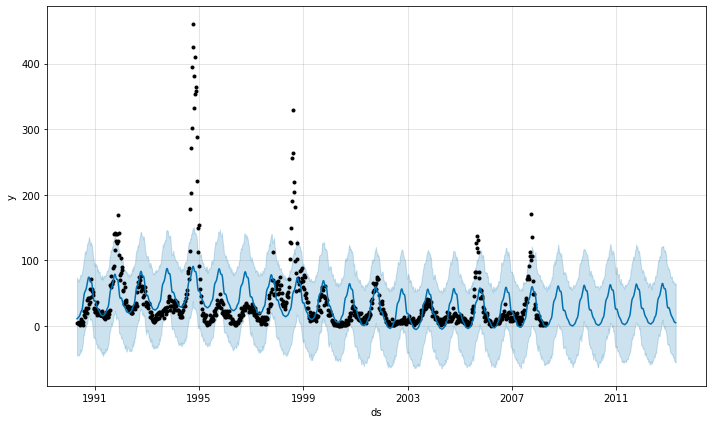

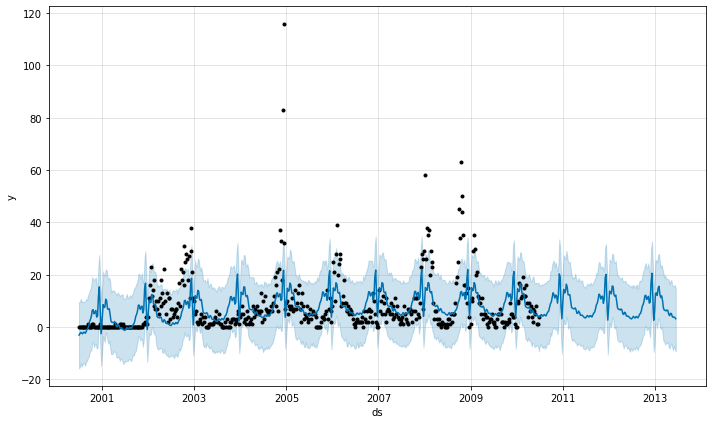

In [0]:
forecast_sj = create_forecast(prophet_data_sj, test_sj, 0.05, 10)
forecast_iq = create_forecast(prophet_data_iq, test_iq, 0.05, 15)

In [0]:
def create_submission(forecast_sj, forecast_iq, sub_name):
    
    test_index = test[['city', 'year', 'weekofyear']]
    
    output = pd.concat([forecast_sj, forecast_iq]).reset_index().drop(['index'], axis=1)
        
    output.columns = ['total_cases']
    
    pd.concat([test_index, output], axis=1).set_index(['city']).to_csv(sub_name + '.csv')

In [0]:
create_submission(forecast_sj, forecast_iq, 'fbprophet')